## Transformer 아키텍처 구현 실습

#### 0. prelims

In [4]:
# numpy 버전 다운그레이드
!pip install "numpy<2" --user
!pip install torch

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/203.1 MB 5.0 MB/s eta 0:00:41
   ---------------------------------------- 0.4/203.1 MB 6.3 MB/s eta 0:00:32
   ---------------------------------------- 0.7/203.1 MB 6.2 MB/s eta 0:00:33
   ---------------------------------------- 1.0/203.1 MB 7.1 MB/s eta 0:00:29
   ---------------------------------------- 1.4/203.1 MB 7.9 MB/s eta 0:00:26
   ---------------------------------------- 1.7/203.1 MB 7.9 MB/s eta 0:00:26
   ---------------------------------------- 2.1/203.1 MB 8.3 MB/s eta 0:00:25
   ---------------------------------------- 2.5/203.1 MB 8.7 MB/s eta 0:00:24
    --------------------------------------- 2.8/203.1 MB 8.6 MB/s eta 0:00:24
    --------------------------------------- 3.3/203.1 MB 8.7 MB/s eta 0:00:23
    --------------------------------------- 3.6/203.1 MB 9.0 MB/s eta 0:00:23
    --------------------------------------- 4.0/203.1 MB 9.1 MB/s eta 0

In [3]:
# numpy 버전 확인
print(np.__version__)

1.26.4


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

#### 1. Standard Encoder-decoder model

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A Standard Encoder-Decoder architecture. Base for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        'Take in and process masked src and tgt in sequences'
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, tgt, src_mask, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    'Define standard linear + softmax generation step'
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

### 2. Encoder and Decoder Stacks

In [ ]:
def clones(layer, N):
    "Produce N identical layers"
    return nn.ModuleList([copy.deepcopy(layer) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) # layers는 6개의 레이어가 iterable하게 생성된 것. 이후 for 문에서 사용됨
        self.norm = LayerNorm(layer.size) # LayerNorm 방식의 정규화
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask) # 여기 layer에 attention과 feed-forward network가 들어감.
        return self.norm(x) # layer 6개를 모두 통과한 x(텐서)가 norm(x)를 통해 정규화됨.

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features)) # features는 실제 벡터 값들의 길이를 말함. 흔히 말하는 벡터의 차원
        self.b_2 = nn.Parameter(torch.zeros(features)) # nn.Parameter로 감싸줘야 이 값들이 업데이트됨.
        self.eps = eps # std가 0이 되는 것을 방지하기 위한 아주 작은 숫자.

    def forward(self, x):
        mean = x.mean(-1, keepdim=True) # -1이란 마지막 차원을 의미
        std = x.std(-1, keepdim=True) # keepdim 텐서의 차원 구조가 변하는 것을 방지
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 # 정규화 계산. a_2는 스케일링 파라미터 / b_2는 시프트 파라미터

In [ ]:
class ResidualConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(ResidualConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout) # Dropout은 신경망 학습 중 일부 뉴런을 무작위로 비활성화하여 과적합을 방지하는 정규화 기법. # dropout parameter는 dropout 비율(0~1)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.residual_connection = clones(ResidualConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.residual_connection[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.residual_connection[1](x, self.feed_forward)

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, size, dropout, self_attn, src_attn, feed_forward):
        super(DecoderLayer, self).__init__()
        self.residual_connection = clones(ResidualConnection(size, dropout), 3)
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.size = size

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.residual_connection[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) # tgt_mask는 생성 위치 뒤의 단어를 참조하지 않도록 하는 마스크
        x = self.residual_connection[1](x, lambda x: self.src_attn(x, m, m, src_mask)) # src_mask는 패딩 마스크
        return self.residual_connection[2](x, self.feed_forward)

In [40]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])


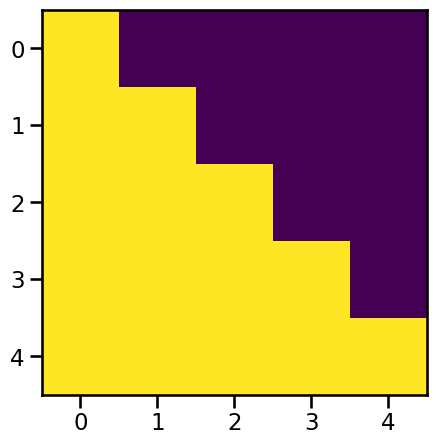

In [42]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(5)[0])

### 3. Attention

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9) # mask에 mask의 위치 정보가 담겨 있음. scores와 같은 shape. mask에서 0인 위치에 해당하는 scores값을 -1e9로 바꿈.
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn) # 그냥 dropout 진행.
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0  # 조건이 False일 경우 오류를 발생시키는 코드.
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4) # key, query, value, output에 각각 적용될 4개의 가중치 행렬
        self.attn = None # 아래에서 배정됨. 그릇만 만든 것.
        self.dropout = nn.Dropout(dropout)  
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1) # apply mask for every vector by broadcasting
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x) # Wo

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))  # x에 가중치 w_2 곱하고 b_2 더함. relu로 변환. dropout 0.1. w_1 가중치 곱하고 b_2 더함

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)  # lut = 임베딩된 벡터 값을 확인하는 look up table
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # 스케일링을 위해서 d_model의 제곱근을 곱해 줌.

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].detach()
        return self.dropout(x)

### 4. Full Model

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model